# M2 | Exploration Notebook

In this notebook, you will do a first exploration of the data set that you will use for your project. One part of this exploration is guided, i.e. we will ask you to solve specific questions (task 1-3). The other part is open, i.e. we will ask you to come up with your own exploration ideas (task 4). 

Please upload your solved notebook to Moodle (under Milestone 2 Submission) adding your SCIPER number in title, example: m2-calcularis-456392.ipynb


## Brief overview of Calcularis
[Calcularis](https://school.alemira.com/de/calcularis/) by Alemira School is a mathematics learning program developed with neuroscientists and computer scientists from ETH Zurich. It promotes the development and interaction of the different areas of the brain that are responsible for processing numbers and quantities and solving mathematical tasks. Calcularis can be used from 1st grade to high school. Children with dyscalculia also benefit in the long term and overcome their arithmetic weakness.


For the guided part of the exploration we will focus on the three main tables:
* ***users***: meta information about users (i.e. total time spent learning with Calcularis, geographic location).
* ***events***: events done by the users in the platform (i.e. playing a game, selecting a new animal in the zoo simulation).
* ***subtasks***: sub-tasks with answer attempts solved by users, primarily in the context of game events.

### Users
* **user_id**: unique identifier of user in database.
* **learning_time_ms**: total learning time in milliseconds per user, totaled over all events. This is calculated by subtracting non-learning time (i.e. if the user is idle for more than one minute).
* **start**: timestamp of initial login.
* **end**: timestamp of last log-off.
* **logged_in_time_ms**: total time between login and log-off, in milliseconds. This will always be larger than learning_time_ms.
* **language**: code for language the user is using Calcularis in (i.e. *fr* for French, *de* for german).
* **country**: code for the country the user is using Calcularis from (i.e. *CH* for Switzerland).

### Events
* **event_id**: unique identifier of event in database.
* **user_id**: user who peformed the event.
* **type**: type of event (task, help, game_start_pause, training_selector, shop, attention_booster, attention_booster_over).
* **mode**: only valid for events of type 'task', representing type of game play (normal, end_of_nr: end of number range, free_training, repetition, favorite, practice).
* **game_name**: name of the game the user is playing. Calcularis has 29 games.
* **learning_time_ms**: total learning time over a single game (event). To see aggregated learning time, examine learning_time_ms in the users table.
* **number_range**: the number range of the exercise (0-10, 0-20, ... 0-1000). The larger the number range, the more difficult the exercise variation.
* **start**: start timestamp of the event.
* **end**: end timestamp of the event.
* **skill_id**: skill number that this game (event) corresponds to.

### Subtasks
*There are many columns in subtasks corresponding to fields present for specific games in Calcularis. More details about corresponding fields for subtasks can be found [here](https://drive.google.com/file/d/1C7bKfHDdKnDzr9-EqWniYoR35ro2QuBd/view?usp=sharing). The fields discussed below are present for the majority of subtasks.*

* **subtask_id**: unique identifier of the subtask in the database.
* **event_id**: unique identifier of event in database.
* **user_id**: user who peformed the event.
* **answer**: the user's answer to the subtask.
* **correct**: `True` if user obtained the correct value in their answer attempt.
* **correctAnswerObject**: the correct answer to the question.
* **hasProperResult**: `True` if this is a question that can be answered by a student. `False` if it corresponds to the SecretNumber game tasks, which consists of counting attempts.
* **range**: number_range for the task (i.e. 0-20 described as R20).
* **subtask_finished_timestamp**: ending timestamp for this subtask (within a specific event).
* **type**: type of subtask event like ConciseEquationTaskDescription, ConciseOrderingTaskDescription (mostly corresponding to individual games, as detailed in the *Subtask Representations* document below).

### Useful Metadata Files
- [Subtask Representations](https://drive.google.com/file/d/1C7bKfHDdKnDzr9-EqWniYoR35ro2QuBd/view?usp=sharing)
- [Number Representations](https://docs.google.com/document/d/1iD60mydGXjB-6HBQakAKI_GGfQaBBQkWcg5eQiAch_A/edit?usp=sharing)
- [Ideas for Calcularis analysis from the Alemira School](https://docs.google.com/document/d/1vM0Gz4f0jStp_wuhBYvnP-VjaBAxzQpVzXomaDfq0D8/edit?usp=sharing)
- [Skill map](https://drive.google.com/file/d/1yJTosk1RV1qzHb-AG_-FLdjlphBsYzoq/view?usp=sharing) representing the relationships between exercises in Calcularis. If you would like to dive deeper into the skill network (programatically), you can use this [.dot file](https://docs.google.com/document/d/1XDPkq7LaAQ3-lAhAvDTLXuiq5u8EKJME/edit?usp=share_link&ouid=104052806655845468726&rtpof=true&sd=true) representing the graph and the corresponding [labels](https://drive.google.com/file/d/1Pkbiz-_bzK80q2l3mkBS_K4wU9sSCY-R/view?usp=sharing).

In [1]:
import numpy as np
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import skewnorm, chi2_contingency
from sklearn.metrics import mutual_info_score

In [2]:
# Import the tables of the data set as dataframes.
def small():
    DATA_DIR = '../data/00_data_1000_students' #You many change the directory

    users = pd.read_csv('{}/calcularis_small_users.csv'.format(DATA_DIR), index_col=0)
    events = pd.read_csv('{}/calcularis_small_events.csv'.format(DATA_DIR), index_col=0)
    subtasks = pd.read_csv('{}/calcularis_small_subtasks.csv'.format(DATA_DIR), index_col=0)
    return users, events, subtasks

def large():
    DATA_DIR = '/mnt/hgfs/Main/EPFL/MLDB/calcData' #You many change the directory

    users = pd.read_csv('{}/full_calcularis_users.csv'.format(DATA_DIR), index_col=0)
    events = pd.read_csv('{}/full_calcularis_events.csv'.format(DATA_DIR), index_col=0)
    subtasks = pd.read_csv('{}/full_calcularis_subtasks.csv'.format(DATA_DIR), index_col=0)
    return users, events, subtasks

#users, events, subtasks = small()
users, events, subtasks = large()

In [47]:
print(users.describe())
users.head(5)

       learning_time_ms  logged_in_time_ms
count          6.49e+04           6.49e+04
mean           2.91e+07           5.28e+07
std            4.03e+07           8.23e+07
min            0.00e+00           0.00e+00
25%            3.10e+06           6.66e+06
50%            1.57e+07           2.87e+07
75%            3.94e+07           6.89e+07
max            1.67e+09           7.79e+09


,learning_time_ms,logged_in_time_ms,language,country,start,end
user_id,,,,,,
2,188171589,588863379,nl,NL,2020-08-20T07:13:38.940Z,2022-12-21T08:43:02.329Z
3,51674473,64077203,de,NaN,2018-02-23T08:29:29.769Z,2019-02-01T09:50:40.447Z
4,73967025,128230675,de,CH,2021-09-06T13:31:50.872Z,2023-02-10T07:57:49.752Z
5,41135378,58146142,de,CH,2022-02-22T10:41:26.754Z,2023-01-24T15:11:29.666Z
6,37110540,61017222,de,CH,2021-10-07T09:23:18.558Z,2022-02-14T18:03:09.583Z


In [86]:
print(f"Percenatge of normal game mode: {events[events['mode'] == 'NORMAL'].count()['mode'] / events.count()['mode'] * 100:.2f}% with total of {events[events['mode'] == 'NORMAL'].count()['mode']}")
print(f"Percenatge of free training game mode: {events[events['mode'] == 'FREE_TRAINING'].count()['mode'] / events.count()['mode'] * 100:.2f}% with total of {events[events['mode'] == 'FREE_TRAINING'].count()['mode']}")
print(f"Percentage of users that have other than free training data: {len(events[events['mode'] != 'FREE_TRAINING']['user_id'].unique()) / len(users.index.unique()) * 100:.2f}%")
print(f"Percentage of users that have an event: {len(events['user_id'].unique()) / len(users.index.unique()) * 100:.2f}%")
print(f"Percentage of true users that have free training data: {len(events[events['mode'] == 'FREE_TRAINING']['user_id'].unique()) / len(users.index.unique()) * 100:.2f}%")
print(f"Percentage of users having events that have free training data: {len(events[events['mode'] == 'FREE_TRAINING']['user_id'].unique()) / len(events['user_id'].unique()) * 100:.2f}%")
print(f"Percentage of users free training & normal data: {len(set(events[events['mode'] == 'FREE_TRAINING']['user_id'].unique()).intersection(set(events[events['mode'] == 'NORMAL']['user_id'].unique()))) / len(events['user_id'].unique()) * 100:.2f}%")
events.head(5)

Percenatge of normal game mode: 36.64% with total of 788924
Percenatge of free training game mode: 2.95% with total of 63447
Percentage of users that have other than free training data: 92.58%
Percentage of users that have an event: 93.03%
Percentage of true users that have free training data: 12.53%
Percentage of users having events that have free training data: 13.47%
Percentage of users free training & normal data: 12.87%


,user_id,mode,game_name,learning_time_ms,subtasks,number_range,start,end,skill_id,type,week
event_id,,,,,,,,,,,
1,2,NORMAL,Subitizing,13094.0,"[{'hasProperResult': True, 'range': 'R10', 'co...",R10,2020-08-20T07:13:50.876Z,2020-08-20T07:14:30.108Z,1.0,task,0
3,2,NORMAL,Conversion,15879.0,"[{'answer': 6, 'range': 'R10', 'correct': True...",R10,2020-08-21T07:02:20.112Z,2020-08-21T07:02:36.221Z,3.0,task,0
4,2,NORMAL,Landing,6075.0,"[{'range': 'R10', 'correct': True, 'lowerBound...",R10,2020-08-24T07:02:59.855Z,2020-08-24T07:03:07.382Z,18.0,task,1
5,2,NORMAL,Landing,6910.0,"[{'range': 'R10', 'correct': True, 'lowerBound...",R10,2020-08-26T06:47:21.504Z,2020-08-26T06:47:30.050Z,19.0,task,1
6,2,NORMAL,Calculator,7507.0,"[{'range': 'R20', 'answerMode': 'RESULT', 'cor...",R20,2020-08-26T07:20:58.766Z,2020-08-26T07:21:06.439Z,54.0,task,1


In [4]:
subtasks.head(5)

,event_id,user_id,aim,answer,answerMode,availableNumbers,correct,correctAnswerObject,correctNumber,destination,...,timeoutInSeconds,timeoutInSteps,type,upperBound,step,orderIndependent,divisor,larger,smaller,timeout
subtask_id,,,,,,,,,,,,,,,,,,,,,
1,1,2,NaN,4,NaN,NaN,False,1,1.0,NaN,...,NaN,NaN,ConciseSubitizingTaskDescription,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,2,NaN,2,NaN,NaN,True,NaN,NaN,NaN,...,0.0,2.0,ConciseTimeoutDescription,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,2,NaN,6,NaN,NaN,True,6,NaN,ARABIC,...,NaN,NaN,ConciseConversionTaskDescription,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,2,7.0,"{'b': 6.7354193, 'a': 7}",NaN,NaN,True,"{'b': 7.0, 'a': 7}",NaN,NaN,...,NaN,NaN,ConciseLandingTaskDescription,7.5,NaN,NaN,NaN,NaN,NaN,NaN
5,5,2,1.0,"{'b': 1.0453212, 'a': 1}",NaN,NaN,True,"{'b': 1.0, 'a': 1}",NaN,NaN,...,NaN,NaN,ConciseLandingTaskDescription,1.5,NaN,NaN,NaN,NaN,NaN,NaN


## Task 1: Simple Statistics

In this task you are asked to do a first coarse exploration of the data set, using simple statistics and visualizations.

#### a) How many distinct participants do we have in the data set?


In [6]:
## Your code goes here
all_ids = pd.Series(pd.concat([events.user_id, pd.Series(users.index), subtasks.user_id]), name='user_id')
print(f"There are across the three dataframes {len(all_ids.unique())} unique user IDs with {len(pd.Series(users.index).unique())} in the users table.")

There are across the three dataframes 64932 unique user IDs with 64932 in the users table.


*Your discussion/interpretation goes here*

Not every participant played a game, to be precise only 926 did, where on average roughly 36 games were played with a standard deviation of 42.5 by each participant. The distribution is **right skewed** and seems to follow a Poisson distribution.
The normality test at least cleary shows that the distribution of played games per user is not a normal distribution.

This distribution makes sense, as most of the participants probably tried playing a few games. On the other hand, either because they solved them fast and quickly went through all levels of difficulty or because they had enough they stopped playing after a few games. Only a small part of all participants played many more games than 150.
The implication of this is, that whenever we try to make corrolations across the games played per user, we on average do not have that many data points of games per user.

#### c) What are the 10 most popular games played (events)? Please provide visualizations of the frequency of the top 10 games.

Hint: See `game_name` in table `events`.

In [9]:
print(f"{len(events.user_id.unique())} users played at least one game.")

60404 users played at least one game.


In [10]:
count_played_games = pd.Series(events.groupby(by="game_name")["user_id"].count(), name="Games played")
count_played_games.sort_values(inplace=True, ascending=False)
# for each game, filter all events to this game and take the unique set of user_ids to count
game_names =events["game_name"].unique()
most_played_games = []
for name in game_names:
    unique_users = events[events.game_name == name]["user_id"].unique()
    c = len(unique_users)
    most_played_games.append(tuple([name, c]))
most_played_games = pd.Series([x[1] for x in most_played_games], index=[x[0] for x in most_played_games])
most_played_games.sort_values(inplace=True, ascending=False)
print(f"Top game was played by {most_played_games[0]/len(events.user_id.unique())*100:.2f}% of participants that ever played a game.")

Top game was played by 97.09% of participants that ever played a game.


The top ten most played games are in order: ['Subitizing', 'Landing', 'Conversion', 'Comparison', 'Distance', 'Estimation on Number Line', 'Calculator', 'Order', 'Secret Number', 'Estimation']


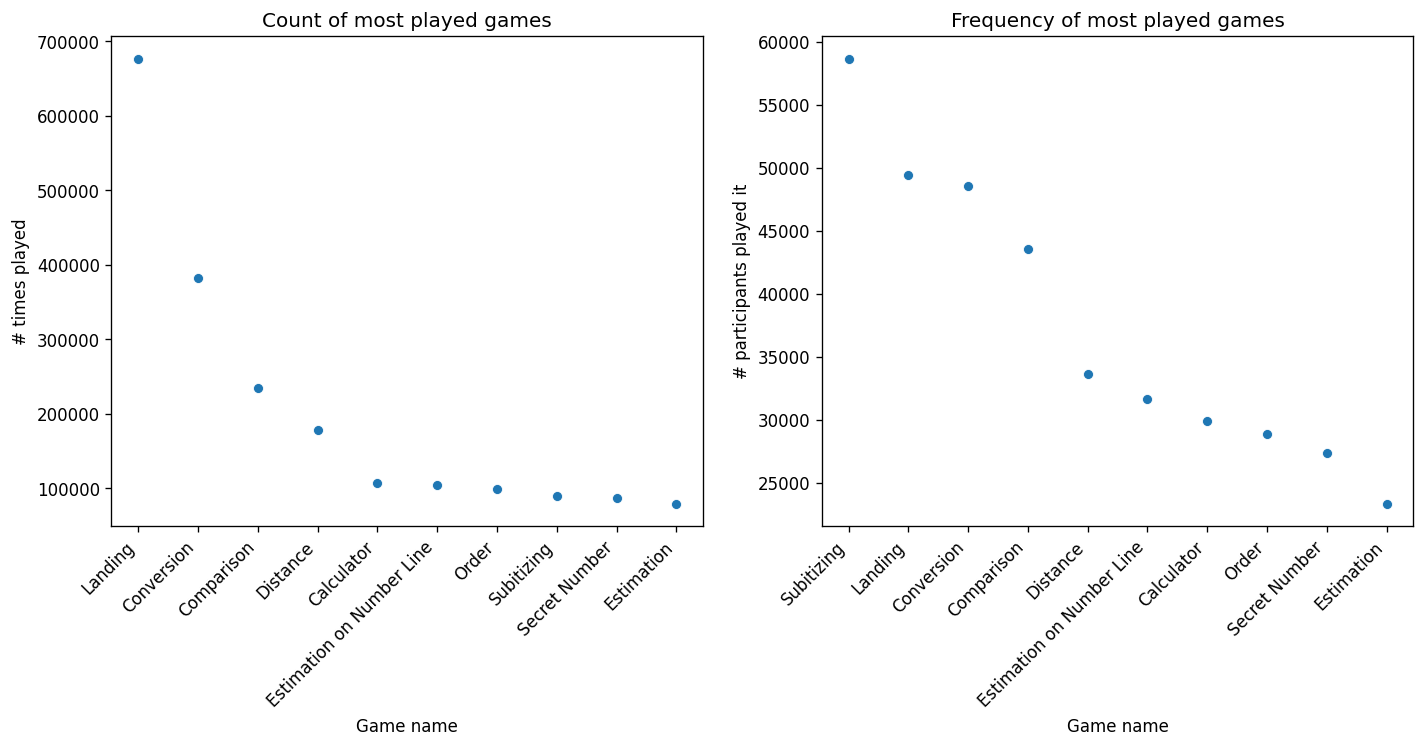

In [11]:
# Prepare visualization & answer of it
print(f"The top ten most played games are in order: {[x for x in most_played_games[0:10].index]}")

fig, axs = plt.subplots(ncols=2, figsize=(14, 6), dpi=120)
sns.scatterplot(data=pd.DataFrame({"Game name": [x for x in count_played_games[0:10].index], "# times played": count_played_games[0:10].values}), x="Game name", y="# times played", ax=axs[0])
axs[0].set_title("Count of most played games")
sns.scatterplot(data=pd.DataFrame({"Game name": [x for x in most_played_games[0:10].index], "# participants played it": most_played_games[0:10].values}), x="Game name", y="# participants played it", ax=axs[1])
fig.autofmt_xdate(rotation=45)
axs[1].set_title("Frequency of most played games")
plt.show()

*Your discussion/interpretation goes here*

The frequency of the games (right plot) shows us how many different (unique) participants played each of the games. The top of those show us the most frequently played games across all users. Interesting to see is that those top 10 games do not perfectly overlap in order with the top 10 most played games seen on the left plot. This means there are some users that played some of the first few games in the count plot (left) very often, while nearly 97% of people played the Subitizing game at least once, even if that game is only the 9th most often played game. This can be interpreted that either this game is very easy or it is the game most people start with/click on most likely, but do not repeatedly play anyways.
The amount of participants that did play the top 10 games does reduces quite a lot, given that after the 5th most frequent game not even half of the participants tried the rest anymore. This shows that about half of the participants mostly play a few games they choose, but do play them more often (except Subitizing).

Another insight from the count plot (left plot) is that there are games (like Landing) that are played many more times by some of the users, because on average Landing would otherwise also be on the first place of the frequency plot.

## Task 2: Static Analysis

In this second task, you will do a univariate an multivariate exploration of some aggregated features.

#### a) Build a data frame containing one row per user:

``[user_id, ui_locale, num_events, num_games, percentage_correct, total_not_learning_time_ms]``


The features are defined as follows:

- **ui_locale**: geographic region the student is from

- **num_events**: total number of events of the student  

- **num_games**: total number of unique games played by the student

- **percentage_correct**: number of correct answers/total number of answers (hint: see `correct` in subtask table).

- **total_not_learning_time_ms**: total amount of ms not spent actively learning

In [12]:
# Your code for building the data frame here
ui_locale_calculatable = pd.Series([f"{lan}-{cou}" for lan, cou in zip(users["language"], users["country"]) if f"{lan}" != "nan" and f"{cou}" != "nan"], name="ui_locale")
ui_locale = ui_locale_calculatable.reindex(users.index, fill_value = np.nan)
#print(ui_locale)

num_events = pd.Series([len(events[events.user_id == i]) for i in users.index], index=users.index, name="num_events")
#print(num_events.describe())

num_games = pd.Series([len(events[events.user_id == i]["game_name"].unique()) for i in users.index], index=users.index, name="num_games")
#sns.histplot(data=num_games, kde=True)
#plt.title("Histogram of unique games played per user")
#plt.show()

hasProperResult_false = len(subtasks[subtasks['hasProperResult'] == False]['hasProperResult'])
print(f"There are {hasProperResult_false} many subtasks that do not have answers that can be answered correctly, which is {hasProperResult_false/len(subtasks[subtasks['hasProperResult'] == True]['hasProperResult'])*100:.2f}%.")
x = subtasks[(subtasks.user_id == 0) & (subtasks.hasProperResult == False)]["correct"].unique()
for i in range(1000):
    x = np.concatenate([subtasks[(subtasks.user_id == i) & (subtasks.hasProperResult == False)]["correct"].unique(), x])
print(f"For hasProperResult False in all subtasks the correct coloumn contains the following values: {np.unique(x)}.")
# A way: First get all subtaks of a user, then remove all those that do not have a proper result. With this we can count how many are true and devide by total amount
# Choosen way: filter for all subtasks that can be correct and are correct as well as all those that can be correct, then filter those per user and divide * 100
user_subtasks_true = subtasks[(subtasks.hasProperResult == True) & (subtasks.correct == True)]
user_subtasks_all = subtasks[(subtasks.hasProperResult == True)]
idx = user_subtasks_all["user_id"].unique()
calculatable_percent = pd.Series(
    [len(user_subtasks_true[user_subtasks_true.user_id == i]) / len(user_subtasks_all[user_subtasks_all.user_id == i]) * 100 for i in idx if len(user_subtasks_all[user_subtasks_all.user_id == i]) > 0],
    index=idx, name="percentage_correct"
)
percentage_correct = calculatable_percent.reindex(users.index, fill_value = np.nan)

total_not_learning_time_ms = users.logged_in_time_ms - users.learning_time_ms
#print(total_not_learning_time_ms)

There are 174102 many subtasks that do not have answers that can be answered correctly, which is 5.23%.
For hasProperResult False in all subtasks the correct coloumn contains the following values: [ True].


In [13]:
# Create the final dataframe
new_df = pd.DataFrame({
  "ui_locale": ui_locale,  
  "num_events": num_events,  
  "num_games": num_games,  
  "percentage_correct": percentage_correct,  
  "total_not_learning_time_ms": total_not_learning_time_ms,  
})
new_df.tail(5)

,ui_locale,num_events,num_games,percentage_correct,total_not_learning_time_ms
user_id,,,,,
64993,NaN,76,10,88.392857,11888904
64994,NaN,24,9,82.352941,2655587
64995,NaN,2,1,50.000000,1876780
64996,NaN,7,5,88.888889,8221031
64997,NaN,82,13,78.125000,23248048


In [50]:
# Save the dataframe to a pickle file
#new_df.to_pickle("../data/new_df.pkl")

b) Perform a univariate analysis (including descriptive statistics and visualizations) for the five features (`ui_locale, num_events, num_games, percentage_correct, total_not_learning_time_ms`) of your dataframe. Please check the lecture slides regarding information on how to perform a univariate analysis for categorical and numerical features. Discuss your results: how are the features distributed? Are there any anomalities?

In [14]:
def get_feature_stats(df):
    """
    Obtains descriptive statistics for all features and percentage of missing values
    
    Parameters
    ----------
    df : DataFrame containing all data

    Returns
    -------
    statistics : DataFrame containing the statistics for all features.
    """
    statistics = df.describe(include="all")
    
    # TODO is this calculation correct?
    ## variance
    var_calc = pd.DataFrame([df.var(axis='rows')], index=['variance'])
    statistics = pd.concat([statistics, var_calc])
    
    ## median
    median_calc = pd.DataFrame([df.median(axis=0)], index=['median'])
    statistics = pd.concat([statistics, median_calc])
    
    ## Calculate the Mode
    mode_calc = pd.DataFrame(stats.mode(df, axis=0, keepdims=True)[0], index=['mode'], columns=df.columns)
    #mode_calc = df.mode(axis=0)
    #mode_calc = pd.DataFrame([mode_calc.max(), mode_calc.min()], index=['mode_max', 'mode_min'])
    statistics = pd.concat([statistics, mode_calc])
    
    # missing values percent
    m_calc = df.isnull().sum(axis = 0)/len(df)*100
    m_calc = pd.DataFrame([m_calc], index=['percentage_missing'])
    statistics = pd.concat([statistics, m_calc])
    
    return statistics

In [15]:
# Your code for univariate analysis here
pd.set_option('display.precision', 2)
print("Descriptive analysis of numerical values:")
numerical_cols = ["num_events", "num_games", "percentage_correct", "total_not_learning_time_ms"]
statistics = get_feature_stats(new_df[numerical_cols])
statistics

Descriptive analysis of numerical values:


,num_events,num_games,percentage_correct,total_not_learning_time_ms
count,64932.00,64932.00,60207.00,6.49e+04
mean,33.65,7.05,74.18,2.38e+07
std,44.31,4.71,17.53,5.69e+07
min,0.00,0.00,0.00,-1.66e+09
25%,4.00,3.00,66.67,2.92e+06
50%,19.00,7.00,77.42,1.04e+07
75%,45.00,10.00,85.71,2.67e+07
max,927.00,27.00,100.00,7.46e+09
variance,1963.68,22.14,307.24,3.24e+15
median,19.00,7.00,77.42,1.04e+07


Excluded the following 877 outlier users from the total_not_learning_time_min graph:
Int64Index([  398,   437,   468,   605,   667,   704,   861,   959,  1145,
             1431,
            ...
            63683, 63687, 63694, 64143, 64285, 64319, 64446, 64480, 64538,
            64956],
           dtype='int64', name='user_id', length=877)



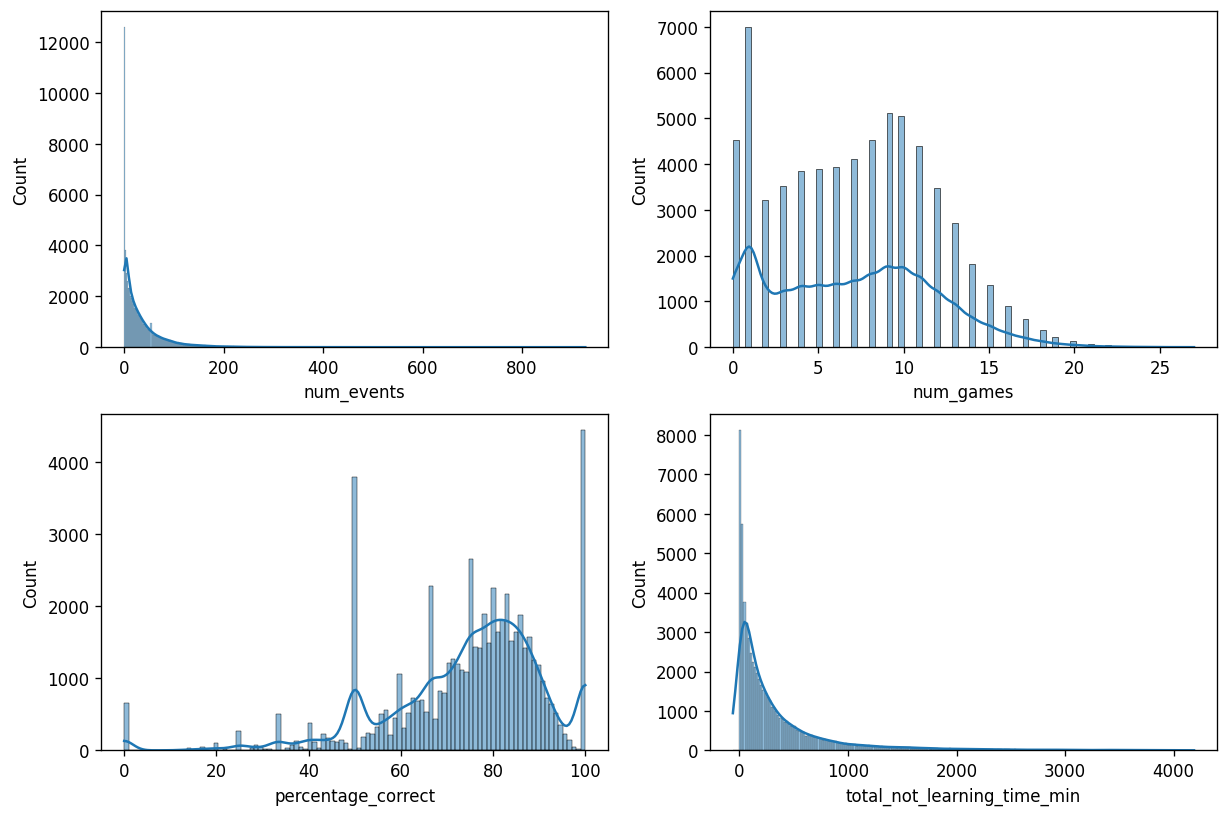

Normality test for num_events:
p = 0
The null hypothesis can be rejected
Normality test for num_games:
p = 0
The null hypothesis can be rejected
Normality test for percentage_correct:
p = 0
The null hypothesis can be rejected
Normality test for total_not_learning_time_ms:
p = 0
The null hypothesis can be rejected


In [16]:
fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(12, 8), dpi=120)
sns.histplot(data=new_df["num_events"], kde=True, ax=axs[0][0])
sns.histplot(data=new_df["num_games"], kde=True, ax=axs[0][1])
sns.histplot(data=new_df["percentage_correct"].dropna(), kde=True, ax=axs[1][0])

# Remove outliers to actually see something on the graph for total_not_learning_time_ms
remove_outlier_not_learning = pd.Series(new_df["total_not_learning_time_ms"]/60000, name="total_not_learning_time_min")
remove_outlier_not_learning = remove_outlier_not_learning[(np.abs(stats.zscore(remove_outlier_not_learning)) < 4)]
outliers_not_learning = remove_outlier_not_learning[(np.abs(stats.zscore(remove_outlier_not_learning)) >= 4)]
print(f"Excluded the following {len(outliers_not_learning)} outlier users from the total_not_learning_time_min graph:")
print(outliers_not_learning.index)
print()
sns.histplot(data=remove_outlier_not_learning, kde=True, ax=axs[1][1])
plt.show()

for col in new_df[numerical_cols].columns:
    print(f"Normality test for {col}:")
    test_normality(new_df[col].dropna())

In [17]:
ui_locale = new_df.ui_locale.value_counts(dropna=False)
pd.DataFrame({"Geographic region": ui_locale.index, "Count": ui_locale.tolist(), "Count %": ui_locale.tolist()/np.sum(ui_locale.tolist())*100 })

,Geographic region,Count,Count %
0,de-CH,28213,4.35e+01
1,NaN,16204,2.50e+01
2,nl-NL,12093,1.86e+01
3,de-DE,4404,6.78e+00
4,fr-CA,1372,2.11e+00
5,fr-CH,724,1.12e+00
6,sv-SE,513,7.90e-01
7,fr-FR,283,4.36e-01
8,de-AT,274,4.22e-01
9,en-CA,213,3.28e-01


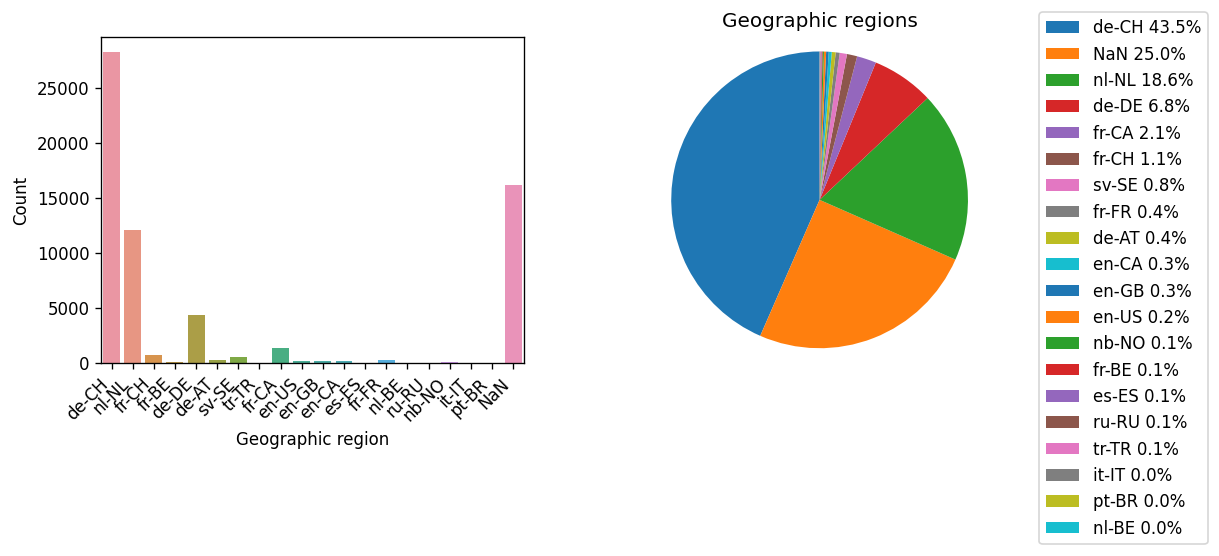

In [18]:
fig, axs = plt.subplots(ncols=2, figsize=(10, 4), dpi=120)
sns.countplot(data=new_df.fillna("NaN"), x='ui_locale', ax=axs[0])
axs[0].set(xlabel='Geographic region', ylabel='Count')
fig.autofmt_xdate(rotation=45)

val_counts = new_df.fillna("NaN").ui_locale.value_counts()/np.sum(new_df.fillna("NaN").ui_locale.value_counts())
labels = val_counts.index.to_list()
axs[1].pie(val_counts, shadow=False, startangle=90)  # No labels or %s
axs[1].axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
axs[1].legend(labels=[f'{x} {np.round(y/sum(val_counts)*100,1)}%' for x,y in val_counts.items()], 
           bbox_to_anchor=(1,1.1))
axs[1].set_title("Geographic regions")
plt.show()

*Your discussion/interpretation goes here:*
*How are the features distributed? Are there any anomalities?*

For all four numerical columns we did a normality test, according to which none of them are distributed according to a normal distribution. This makes a lot of sense for both the number of events and the time participants were logged in but didn't play, because for both of these of the participants that did try working on the problems, less and less people kept at it, which results in the right skewed distributions we see.
The total_not_learning_time_ms has very big outliers, which is why for the graphical analysis above I removed nine outlier users with a zscore smaller than four as without this removal the graph is illegible because of the axis adjustments needed for them.
These nine users, as well as some more that make the distribution very right skewed, often or for very long periods of time stayed logged in while being idle. 

The histogram of number of games played per users is harder to recognize as not being normally distributed (the normality test tells us so), because it does seem like a multi modal distribution of maybe two normal distributions. Even though it is lightly right skewed, this makes sense in that after trying a few games fewer and fewer participants try even more other different games the longer they already played.
For both the number of games and events played their standard deviation shows us that there is a wide range of times the different participants played, the interpretation of which could be that there are two types of participants, those that play often and those that just tried playing a few different games but did not keep going.

The last numerical value is the percentage of correct answers for each participant. In this coloumn we have some NaN because there exist participants that did not play any games yet, which results in the percentage of correct answers not making any sense. Further there exist subtasks, for which a "correct" answer can not be given (those that have the "hasProperResult" false, 5.42% of all subtasks). These subtasks are not counted within this data, because again a percentage for them does not make sense. Looking at the histogram of those users that have a value shows a very left skewed distribution, which is not normally distributed according to the normality test. The peak around 80 percent makes complete sense, because most participants will be working with this platform to learn until they know most of the content well, but seldomely manage to do so with answering all questions correctly.

The only categorical data is for the geopgraphic region users come from. This feature is created by looking not only at the country they come from, but also the language they belong to. Roughly 25% of users have a NaN for this feature, because either their country, language or both were are missing in the raw data. Further nearly half of all participants in our data are part of the de-CH geografic region, which makes sense given that Calcularis is developed in switzerland starting from ETH (mostly german speaking). Another noteworthy point about the geopgraphicall regions is that there are quite a few regions that have single or very low users counts, which means we can not really make any meaningful predictions out of those regions.

c) Come up with two additional features on your own and add them to the dataframe. Please provide an explanation/description of your features as well as an argument/hypothesis of why you think these features are interesting to explore.

In [23]:
# Your code for computing the features and adding them to the df goes here
# The time each participant was in an event of type task (the amount of time spent playing the tasks)
dif = events.join(pd.Series(pd.to_datetime(events['end'], infer_datetime_format=True) - pd.to_datetime(events['start'], infer_datetime_format=True), name="time_spent"))
dif = dif[dif.type == 'task']
dif = pd.Series(dif.groupby(by="user_id").apply(lambda x: x["time_spent"].sum() / np.timedelta64(1, 'ms')), name="time_spent_in_tasks_ms")

# Summing up the learning time across the modes
print(f"Modes in the dataset: {events['mode'].unique()}")
modes = ['END_OF_NR', 'NORMAL', 'FREE_TRAINING', 'PRACTICE', 'FAVORITE', 'REPETITION']
mode_renames = {
    mode: f"{mode}_learning_time_ms" for mode in modes
}
print(f"{len(events[events.type == 'task'])/len(events)*100:.2f}% of events are tasks")
only_tasks = events[events.type == "task"]
# Group the tasks by user_id and mode to sum them up
time_in_modes = only_tasks.groupby(by=["user_id", "mode"]).apply(lambda x: x["learning_time_ms"].sum())
# reset the index to have the correct form for reshaping
time_in_modes = time_in_modes.reset_index(level=["user_id", "mode"]).rename(columns={0: "mode_learning_time_ms"})
# reshape it to have each user in a row
time_in_modes = pd.pivot(time_in_modes, index=['user_id'], columns = 'mode', values = 'mode_learning_time_ms').rename(columns=mode_renames)
time_in_modes = time_in_modes.reindex(users.index, fill_value = np.nan)#.fillna(0)
modes_columns = time_in_modes.columns
#assert len(time_in_modes.columns) == len(modes)
#time_in_modes = time_in_modes.divide(users["learning_time_ms"], axis=0)

# Join into a new datafram
extended_df = new_df.join(dif).join(time_in_modes)
extended_df.tail(5)

Modes in the dataset: ['NORMAL' 'END_OF_NR' nan 'FREE_TRAINING' 'FAVORITE' 'PRACTICE'
 'REPETITION']
98.54% of events are tasks


,ui_locale,num_events,num_games,percentage_correct,total_not_learning_time_ms,time_spent_in_tasks_ms,END_OF_NR_learning_time_ms,FAVORITE_learning_time_ms,FREE_TRAINING_learning_time_ms,NORMAL_learning_time_ms,PRACTICE_learning_time_ms,REPETITION_learning_time_ms
user_id,,,,,,,,,,,,
64993,NaN,76,10,88.39,11888904,9.24e+05,565910.0,NaN,NaN,125530.0,NaN,NaN
64994,NaN,24,9,82.35,2655587,3.95e+05,156715.0,NaN,NaN,122369.0,NaN,NaN
64995,NaN,2,1,50.00,1876780,1.09e+04,NaN,NaN,NaN,4997.0,NaN,NaN
64996,NaN,7,5,88.89,8221031,1.22e+05,1434.0,NaN,NaN,29743.0,NaN,NaN
64997,NaN,82,13,78.12,23248048,1.69e+06,889837.0,NaN,NaN,315974.0,NaN,NaN


*Your feature descriptions and arguments/hypotheses go here:*
*Provide an explanation/description of your features as well as an argument/hypothesis of why you think these features are interesting to explore.*

My first additional feature is how much time was spent by the participants in the tasks part of the calcularis game. This feature is a simple summation over the substraction of end time minus start time of each event type task. This feature seems interesting, as the time spent in tasks is different to the time spent logged in and it is where participants most likely actually do learn something, i.e. the time in menues and similar does not help them learn the concepts. This feature is also very interesting in confrontation with the next set of features I added.

This "second" feature consists of multiple columns in the wide format we are required to have per user and shows how much learning time each user spent in the different modes of the tasks. To get these features we first group by user_id and mode and then reshape the result into a format that fits the new_df dataframe. The hypothesis I try to validate with these features is that the time spent in modes like practice or free training compared to the first feature of how much total time was spent in the tasks can tell us something about how confident/good the participant is in answering the questions (comparision also to percentage correct).

d) Perform a univariate analysis of your features (including descriptive statistics and visualization). What can you observe? Do the results confirm your hypotheses?

In [24]:
# Your code for univariate analysis goes here
new_feature_names = np.append(modes_columns.values, "time_spent_in_tasks_ms")
statistics = get_feature_stats(extended_df[new_feature_names])
statistics

,END_OF_NR_learning_time_ms,FAVORITE_learning_time_ms,FREE_TRAINING_learning_time_ms,NORMAL_learning_time_ms,PRACTICE_learning_time_ms,REPETITION_learning_time_ms,time_spent_in_tasks_ms
count,4.37e+04,5.34e+03,8.14e+03,5.98e+04,1.08e+03,6.00e+00,6.02e+04
mean,5.16e+05,2.74e+04,1.56e+05,2.12e+05,1.17e+05,3.88e+04,1.08e+06
std,1.55e+06,4.66e+04,3.18e+05,1.24e+06,2.49e+05,4.67e+04,4.60e+06
min,3.20e+02,3.15e+02,3.51e+02,3.19e+02,2.24e+02,8.68e+02,-1.80e+01
25%,8.36e+04,6.07e+03,1.20e+04,4.81e+04,1.00e+04,2.75e+03,1.84e+05
50%,2.58e+05,1.22e+04,5.45e+04,1.16e+05,3.16e+04,2.40e+04,5.41e+05
75%,6.21e+05,2.92e+04,1.64e+05,2.45e+05,1.07e+05,5.82e+04,1.26e+06
max,2.48e+08,6.98e+05,8.17e+06,2.65e+08,3.76e+06,1.19e+05,6.88e+08
variance,2.40e+12,2.17e+09,1.01e+11,1.54e+12,6.20e+10,2.18e+09,2.12e+13
median,2.58e+05,1.22e+04,5.45e+04,1.16e+05,3.16e+04,2.40e+04,5.41e+05


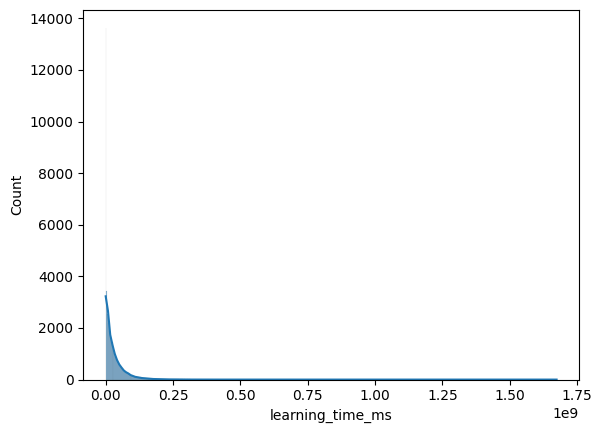

In [25]:
# Plot of the normal learning time in ms per user (to compare it visually with my new feature)
sns.histplot(data=users["learning_time_ms"], kde=True)
plt.show()

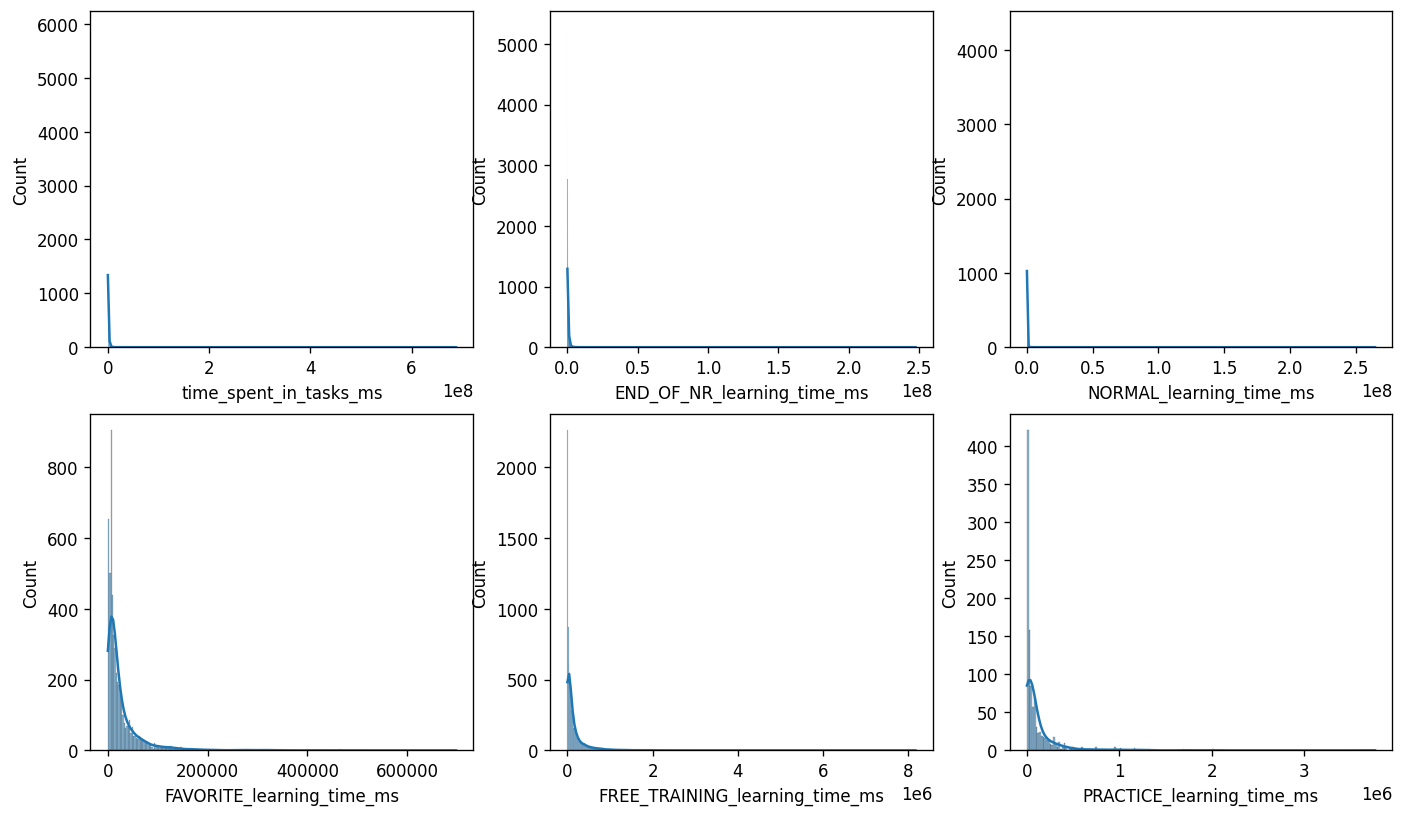

Normality test for END_OF_NR_learning_time_ms:
p = 0
The null hypothesis can be rejected
Normality test for FAVORITE_learning_time_ms:
p = 0
The null hypothesis can be rejected
Normality test for FREE_TRAINING_learning_time_ms:
p = 0
The null hypothesis can be rejected
Normality test for NORMAL_learning_time_ms:
p = 0
The null hypothesis can be rejected
Normality test for PRACTICE_learning_time_ms:
p = 1.18482e-280
The null hypothesis can be rejected
Normality test for REPETITION_learning_time_ms:


ValueError: skewtest is not valid with less than 8 samples; 6 samples were given.

In [26]:
fig, axs = plt.subplots(ncols=3, nrows=2, figsize=(14, 8), dpi=120)
sns.histplot(data=extended_df["time_spent_in_tasks_ms"], kde=True, ax=axs[0][0])
sns.histplot(data=extended_df["END_OF_NR_learning_time_ms"], kde=True, ax=axs[0][1])
sns.histplot(data=extended_df["NORMAL_learning_time_ms"], kde=True, ax=axs[0][2])

sns.histplot(data=extended_df["FAVORITE_learning_time_ms"], kde=True, ax=axs[1][0])
sns.histplot(data=extended_df["FREE_TRAINING_learning_time_ms"], kde=True, ax=axs[1][1])
sns.histplot(data=extended_df["PRACTICE_learning_time_ms"], kde=True, ax=axs[1][2])
plt.show()

for col in new_feature_names:
    print(f"Normality test for {col}:")
    test_normality(extended_df[col].dropna())

*Your discussion/interpretation goes here:*
*What can you observe? Do the results confirm your hypotheses?*

The first clear observation is that, similarly to the original feature of not learning time, all these summations of time spent doing different tasks are very right skewed distributions (none of which are normally distributed). Because there are participants that did not spent any time in some of the task modes (a NaN in the respective field of the feature), another clear observation is that we have many more participants that played the "normal" and "end of nr" learning modes than the others. This insight could be skewed because these tests are done on a subset of the whole data, but we do not have yet access to all of the data. By far the least participants played ever in practice mode. By looking at the standard deviation and mean we can additionally see that the spread of time invested in the different modes varies immensly between participants.

The histogram of the time spent in tasks compared to the one of the total leaning time in ms shows a very similar distribution. The hypothesis that this feature is more interesting than the "normal" learning time cannot be rejected, because the distribution of the "normal" learning time is much more right skewed (pay attention to the power of the x axis), which can be interpreted as participants spending less time actually learning inside tasks compared to their total learning time.

One interesting point of the second feature is that the counts of the different modes shows a wide difference in how often the different modes were played. Because my hypothesis for this features is based on comparisions to other features this univariat analysis did neither confirm nor deny my hypothesis yet.

e) Perform a multivariate analysis for two pairs of features of your choice. Please provide a metric and a visualization for both pairs. Please discuss: why did you choose these two pairs? What was your hypothesis? Do the results confirm your hypothesis?

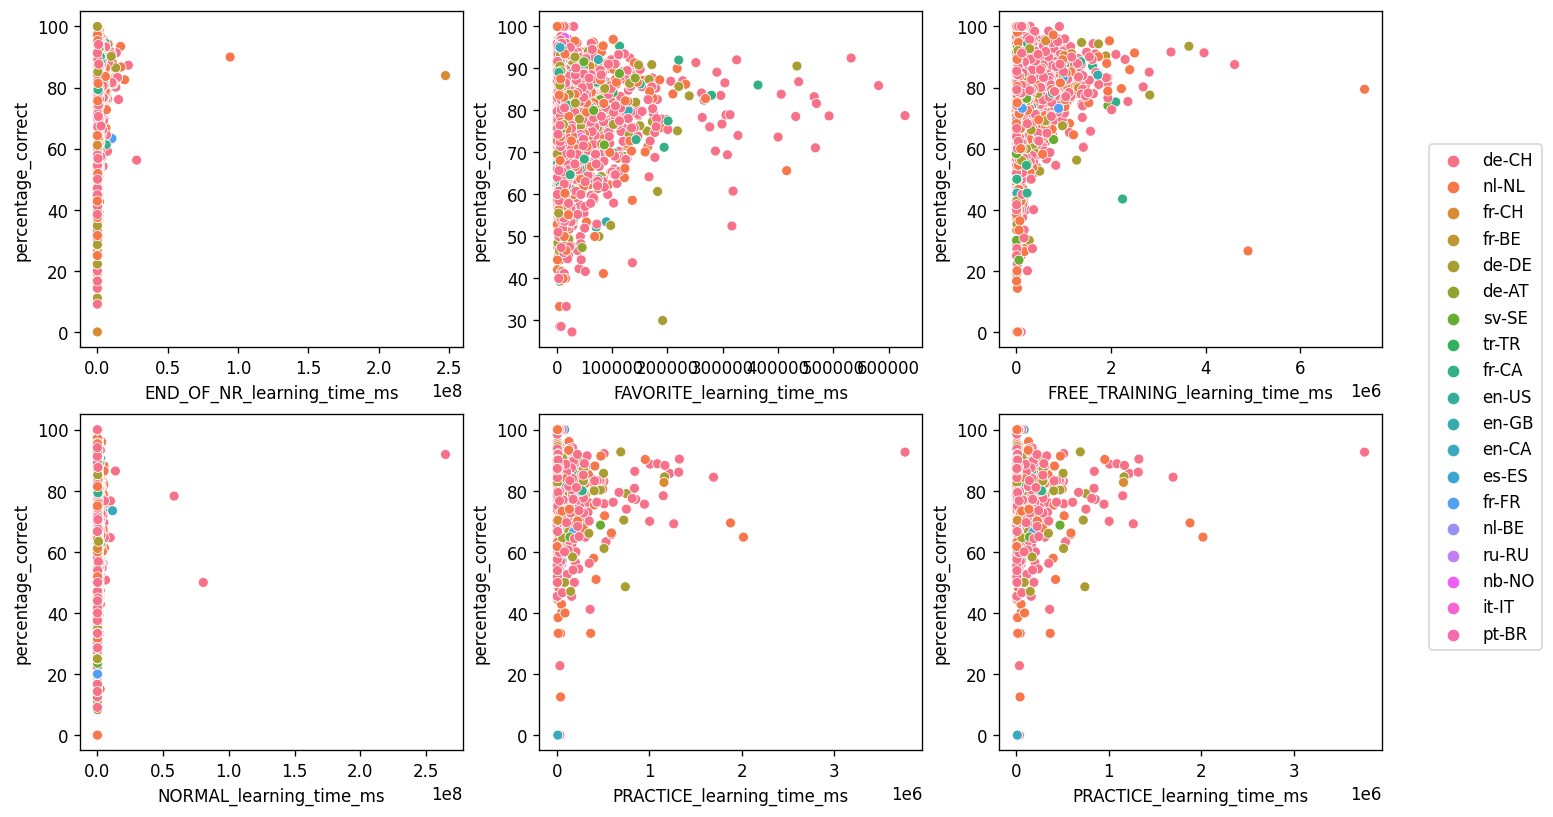

In [31]:
# Your code for multivariate analysis goes here

fig, axs = plt.subplots(ncols=3, nrows=2, figsize=(14, 8), dpi=120)
# Time spent in modes and percentage correct
sns.scatterplot(data=extended_df, y = 'percentage_correct', x ='END_OF_NR_learning_time_ms', ax=axs[0][0], hue="ui_locale", legend = False)
sns.scatterplot(data=extended_df, y = 'percentage_correct', x ='FAVORITE_learning_time_ms', ax=axs[0][1], hue="ui_locale", legend = False)
sns.scatterplot(data=extended_df, y = 'percentage_correct', x ='FREE_TRAINING_learning_time_ms', ax=axs[0][2], hue="ui_locale", legend = False)
sns.scatterplot(data=extended_df, y = 'percentage_correct', x ='NORMAL_learning_time_ms', ax=axs[1][0], hue="ui_locale", legend = False)
sns.scatterplot(data=extended_df, y = 'percentage_correct', x ='PRACTICE_learning_time_ms', ax=axs[1][1], hue="ui_locale", legend = False)
#sns.scatterplot(data=extended_df, y = 'percentage_correct', x ='REPETITION_learning_time_ms', ax=axs[1][2], hue="ui_locale", legend = True)
# Time spent in tasks and percentage correct
sns.scatterplot(data=extended_df, y = 'percentage_correct', x ='PRACTICE_learning_time_ms', ax=axs[1][2], hue="ui_locale", legend = True)
axs[1][2].get_legend().remove()
#plt.xlabel("Total time in Tasks")
#plt.ylabel("Percentage correct answers")
handles, labels = axs[1][2].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right', bbox_to_anchor=(1, 0.75))
plt.show()

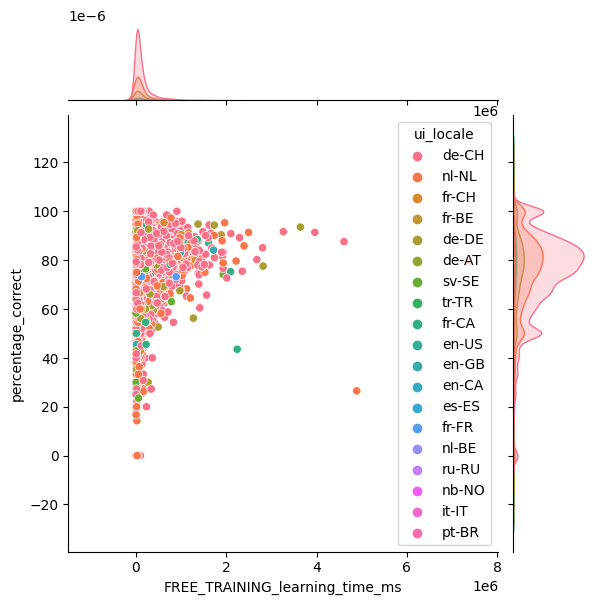

In [32]:
# Look at one of the more filled graphs also with a jointplot
ax = sns.jointplot(data=extended_df, y = 'percentage_correct', x ='FREE_TRAINING_learning_time_ms', hue="ui_locale", legend = True)
plt.show()

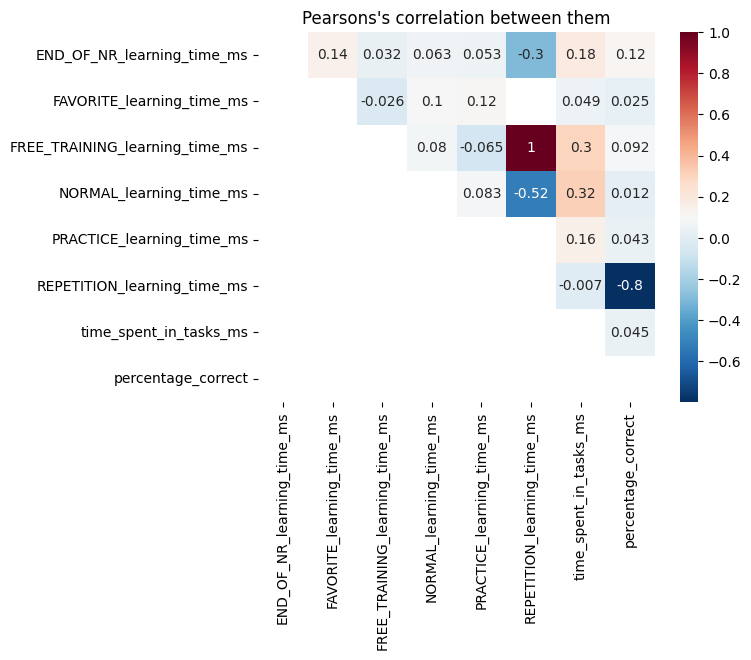

In [33]:
corr = np.round(extended_df[np.append(new_feature_names, "percentage_correct")].corr(method='pearson'), 3)
mask = np.tril(corr)
ax = plt.axes()
heatmap = sns.heatmap(corr, annot=True, mask=mask, cmap='RdBu_r')
ax.set_title("Pearsons's correlation between them")
plt.show()

*Your discussion/interpretation goes here:*
*Why did you choose these two pairs? What was your hypothesis? Do the results confirm your hypothesis?*

For the newly added features we again might have effects that are artefacts from now running these tests on the whole set of data, i.e. some datapoints might give us wrong answers. We did not get access to the full data in time for me to do these tests on the full data.

For my multivariate analysis I choose my two new features with the percenatge of correct answers. The first feature comparision to the percentage can answer my hypothesis of this feature being interesting and correlating well to the percentage of correct answers, which as it turn out does not really hold with a correlation of just 0.16. The comparision of the time spent in different modes with the percentage of correct answer and between themselves I did to answer the hypothesis that there are specific modes that better tell us how confident this participant is and at the same time how correct.

Contrary to my initial hypothesis there does not seem to be a strong linear correlation between any of the learning times spent in the different modes and the percentage of correct answers. The highest between them being the amount of free training and practice to percentage of correct answers with 0.18. As such my hypothesis was rejected and these features do not show us anything very interesting.

Time spent between the different modes though, does show linear correlation between some of them. Namely the amount of time spent free training and favourite, with a correlation of 0.35 and practice and favourite as well as between practice mode and free training with a negative correlation of -1 and -0.43, respectively. The meaning of the former could be that participants that do free traning also use the favourite feature, but we do not have that many datapoints for both of these features, hence this might be just a realisation of that fact. The latter means that noone of the few participants that did do either practice or favourite mode didn't do the other and if a participant is spending time in practice mode they spent less of it in traning mode, which could be because the two modes are very similar.
Further time spent in normal mode does correlate with 0.80 to the time spent in tasks in general, which makes sense when remembering that the normal mode is by far the mode with the highest percentage of learning time spent by the participants.

Lastly an insight from the correlation plots with hue of the geopgraphic locations shows as that the results of these correlation calculations seems to not depend on the geographic region.

# Task 3: Time-Series Analysis

In the last task, you will perform a time-series analysis.


#### a) Build a data frame containing one row per user per week:

``[user_id, week, num_events, num_questions, percentage_correct, num_shop]``


The features are defined as follows:

- **num_questions**: total number of questions the student answered **per week**.

- **num_events**: total number of events of the student per week.

- **percentage_correct**: number of correct answers/total number of answers  **per week** (hint: answer = correct). If desired, you may assign a weight of 0.5 to partially correct answers.

- **num_shop**: total number of shop events **per week** (where the student wins animals for their zoo with rewards from the games).

Where week 0 is the first week the specific user solved a task in the platform, i.e., the user's earliest entry in the subtasks table.

Hint: You may extract the week of the year (dt.week) from the timestamps. 

You can limit the number of weeks to 13, i.e. for each user we just look at the first 13 weeks of data.
Yoy may change and justify your choice for the number of weeks.

In [34]:
total_shops = events[events["type"] == "SHOP"].count()["user_id"]
print(f"In total there are {total_shops} SHOP events...")

In total there are 1449 SHOP events...


In [35]:
years = pd.to_datetime(events['start'], infer_datetime_format=True).dt.isocalendar().year
first_year = years.min()
print(f"The first year someone started is {first_year}")

The first year someone started is 2015


In [36]:
test = pd.to_datetime(subtasks['subtask_finished_timestamp'], infer_datetime_format=True).dt.isocalendar().week.replace(np.NaN, 9999)
test2 = pd.to_datetime(events['start'], infer_datetime_format=True).dt.isocalendar().week.replace(np.NaN, 9999)
print(f"Percentage of NaNs in subtasks: {len(test[test == 9999])/len(test)*100:.02f}% and in events: {len(test2[test2 == 9999])/len(test2)*100:.02f}%")

Percentage of NaNs in subtasks: 16.55% and in events: 0.00%


In [37]:
# Your code for building the dataframe goes here
weeks_a_year = 52 # Using 53 weeks to account for additional years would skew our data more than keeping it at 52 does.
events["week"] = pd.to_datetime(events['start'], infer_datetime_format=True).dt.isocalendar().year-first_year
events["week"] = events["week"]*weeks_a_year+pd.to_datetime(events['start'], infer_datetime_format=True).dt.isocalendar().week
start_weeks = pd.Series(events.groupby(by="user_id").min()["week"], name="start_weeks")
subtasks["week"] = pd.to_datetime(subtasks['subtask_finished_timestamp'], infer_datetime_format=True).dt.isocalendar().year-first_year
subtasks["week"] = subtasks["week"]*weeks_a_year+pd.to_datetime(subtasks['subtask_finished_timestamp'], infer_datetime_format=True).dt.isocalendar().week
# Now actually change it to each user starting with week 0
for user, start in start_weeks.items():
    events.loc[events["user_id"] == user, "week"] = events[events["user_id"] == user]["week"]-start
    subtasks.loc[subtasks["user_id"] == user, "week"] = subtasks[subtasks["user_id"] == user]["week"]-start

# now we group by user_id and week to count how many events & questions (i.e. answers) each user had per week
num_questions = pd.Series(subtasks.groupby(by=["user_id", "week"]).count()["correct"], name="num_questions")
num_events = pd.Series(events.groupby(by=["user_id", "week"]).count()["mode"], name="num_events")

# TODO figure out how to compare answers for not correct to find partial correct answers
num_correct_answers = pd.Series(subtasks[(subtasks.hasProperResult == True) & (subtasks.correct == True)].groupby(by=["user_id", "week"]).count()["correct"], name="num_correct_answers")
num_answers_answerable = pd.Series(subtasks[(subtasks.hasProperResult == True)].groupby(by=["user_id", "week"]).count()["correct"], name="num_answers_answerable")
num_correct_answers = num_correct_answers.reindex(num_answers_answerable.index, fill_value = 0)
percentage_correct_week = num_correct_answers/num_answers_answerable*100

num_shop = pd.Series(events[events["type"] == "SHOP"].groupby(by=["user_id", "week"]).count()["type"], name="num_shop")

/tmp/ipykernel_204638/2313433371.py:5: FutureWarning: Dropping invalid columns in DataFrameGroupBy.min is deprecated. In a future version, a TypeError will be raised. Before calling .min, select only columns which should be valid for the function.
  start_weeks = pd.Series(events.groupby(by="user_id").min()["week"], name="start_weeks")


In [38]:
# Create the final dataframe
ts_df = pd.DataFrame({
  "num_events": num_events,  
  "num_questions": num_questions,  
  "percentage_correct": percentage_correct_week,  
  "num_shop": num_shop,  
})
# Cleanup the df a bit with 0 for the NaN where it makes sense
ts_df[['num_shop', 'num_questions']] = ts_df[['num_shop', 'num_questions']].fillna(value=0)

In [49]:
# Save the dataframe to a pickle file
#ts_df.to_pickle("../data/ts_df.pkl")

#### b) Select two features and analyze their behavior over time. Please provide a hypothesis and visualization for both features. For ideas on how to perform a time series exploration, please check the lecture slides and notebook. Discuss your results: what do you observe? Do the results confirm your hypotheses?

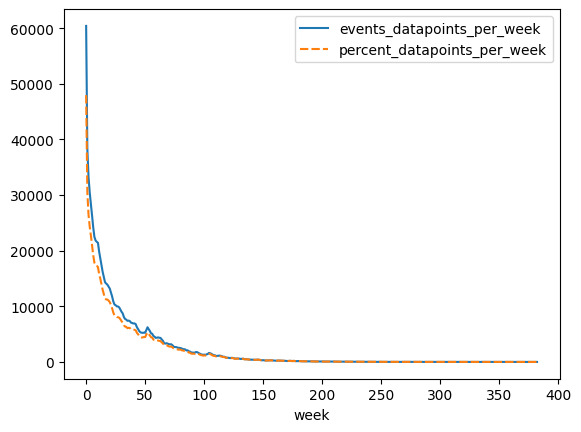

                    events_datapoints_per_week  percent_datapoints_per_week
count                                 3.82e+02                     3.82e+02
mean                                  2.42e+03                     2.00e+03
std                                   6.06e+03                     4.85e+03
min                                   1.00e+00                     1.00e+00
25%                                   6.25e+00                     6.25e+00
50%                                   1.00e+02                     1.00e+02
75%                                   1.63e+03                     1.46e+03
max                                   6.04e+04                     4.80e+04
variance                              3.68e+07                     2.35e+07
median                                1.00e+02                     1.00e+02
mode                                  1.00e+00                     1.00e+00
percentage_missing                    0.00e+00                     0.00e+00


In [39]:
# Looking ad the different amount of datapoints we have in the new ts_df
events_datapoints_per_week = pd.Series(ts_df.groupby(by="week").count()["num_events"], name="datapoints_per_week")
percent_datapoints_per_week = pd.Series(ts_df.groupby(by="week").count()["percentage_correct"], name="datapoints_per_week")
datapoints_per_week = pd.DataFrame({
  "events_datapoints_per_week": events_datapoints_per_week,  
  "percent_datapoints_per_week": percent_datapoints_per_week,  
})
ax = sns.lineplot(data=datapoints_per_week)
plt.show()
# We notice a difference in the graph, so what should we choose for the rest of the analysis?
print(get_feature_stats(datapoints_per_week))

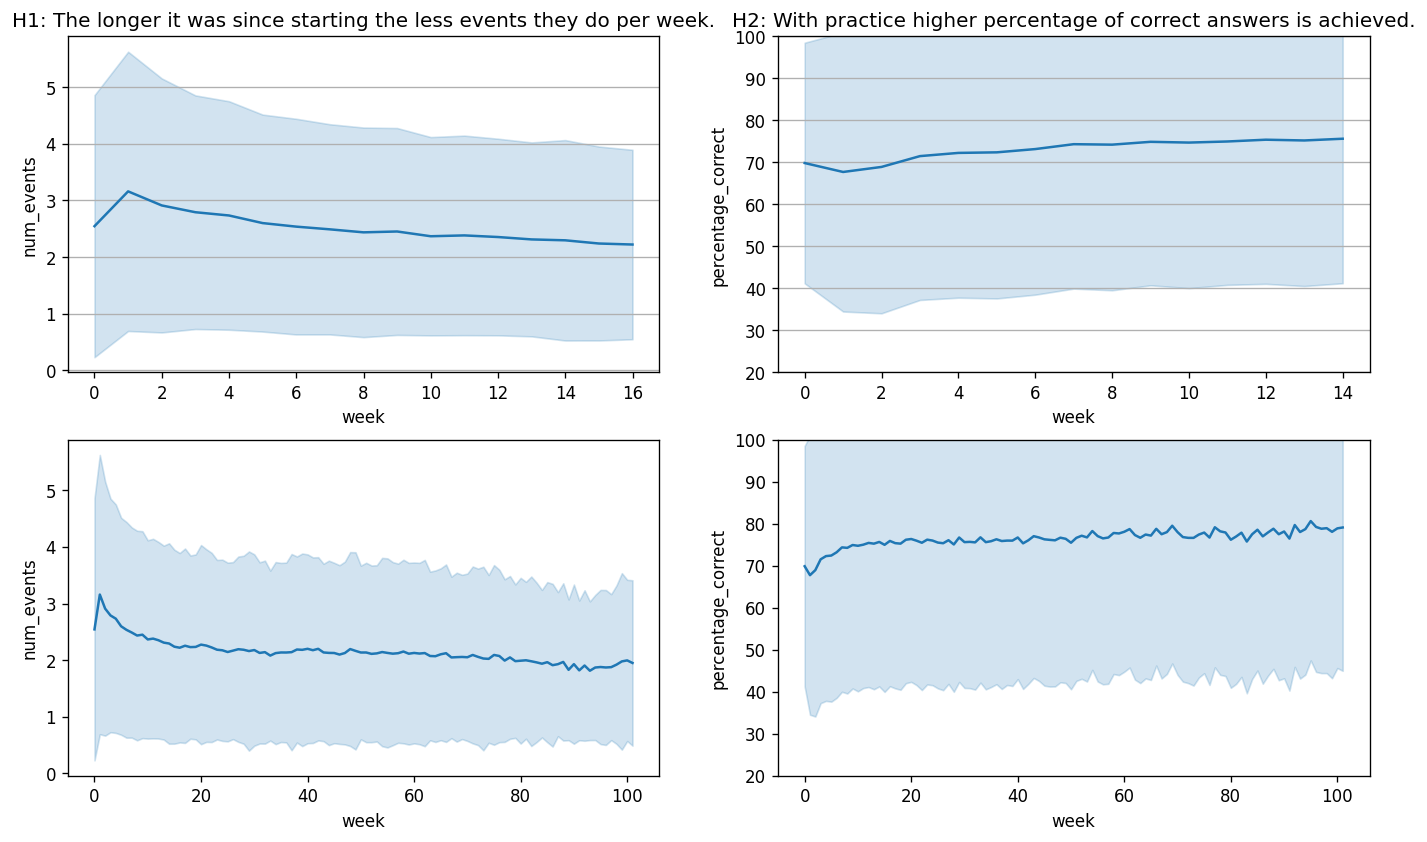

In [42]:
fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(14, 8), dpi=120)
# Because the 75 percentile for both is a bit different, lets use only weeks up to each of them. This way we have a useful mean while still getting most datapoints we do have
axs[0][0].yaxis.grid(True)
axs[0][0].set_title("H1: The longer it was since starting the less events they do per week.")
sns.lineplot(data=ts_df[ts_df.index.get_level_values(1) <= events_datapoints_per_week.quantile(q=0.50)+1], x="week", y="num_events", errorbar='sd', ax=axs[1][0])
sns.lineplot(data=ts_df[ts_df.index.get_level_values(1) <= 16], x="week", y="num_events", errorbar='sd', ax=axs[0][0])
axs[0][1].yaxis.grid(True)
axs[0][1].set_title("H2: With practice higher percentage of correct answers is achieved.")
sns.lineplot(data=ts_df[ts_df.index.get_level_values(1) <= percent_datapoints_per_week.quantile(q=0.50)+1], x="week", y="percentage_correct", errorbar='sd', ax=axs[1][1]) #, hue="num_shop")
sns.lineplot(data=ts_df[ts_df.index.get_level_values(1) <= 14], x="week", y="percentage_correct", errorbar='sd', ax=axs[0][1])
axs[0][1].set_ylim(20, 100)
axs[1][1].set_ylim(20, 100)
plt.show()

*Your discussion goes here:*
*What do you observe? Do the results confirm your hypotheses?*

I understood the question to mean we have a multicolumn index of user_id and week, where the latter consists of the week number starting with 0 in the first week this participant did a single event. Further to my understanding the definition of a "question" is a single subtask entry, as those even define when a task/question was answered. Calculating the percentage of correct answers makes only sense for those that have a proper answer, meaning not all users that do have subtasks might have a percentage. Lastly is the point of how many weeks to show in the graphs for them to be relevant, although the question asks for 13 weeks, I plot both features for both the median amount and the 75 percentile. The former to get a look at what most of my data shows, without nearly all outliers. The latter to see how the data evolves when looking at most of the datapoints we do have.

The first feature I looked at was the number of events per week to try and answer the following hypothesis: "The longer it was since starting with calcularis for a participant the less events they do per week."
The graph of sixteen weeks shows a light decline in the number of events done per participant, seeming to accept my hypothesis, which would also be consistent with what one expects from participants trying out a new system. The standard deviation shows that there is a very big difference in how many events the different participants did during their use of the platform, but even that shows the downward trend of events with time since start. Looking at the longer running graph we can see that this same downward trend continues for some more weeks after the 16th, but then dies out or at least is not really recognizable anymore under the noise. 


The second feature I looked at was the percentage of correct answers with time. This feature I was interested in looking at for the hypothesis of "practice makes perfect" or in more elaborate terms, the more practice the participants get on the platform the higher is the percentage of correct answers they have in any given week.
Again, the most significant part of the data (looking at the graph with the median number of weeks) seems to show that the average of participants increased their percentage of correct answers roughly by 10 percent from 70 to 80%. Looking at the variance in that graph though, we can clearly see that there is a very big spread across nearly the full percentage range, which indicates to me that more finegrained analysis of this data in respect to other factors are necessary to fully accept the hypothesis.

Out of curiosity I also added as hue the number of shop events to the longer running percentage graph, which leads to the low confidence insight that those that did well and gained higher percentage correct do seem to also have at least seen the shop feature.

# Task 4: Creative extension 

Please provide **one** new hypothesis you would like to explore with the data and provide a visualization for it. Discuss your results: what do you observe? Do the results confirm your hypotheses?



In [43]:
test = pd.merge(subtasks, events, left_on=  ['event_id'],
                   right_on= ['event_id'], 
                   how = 'left')

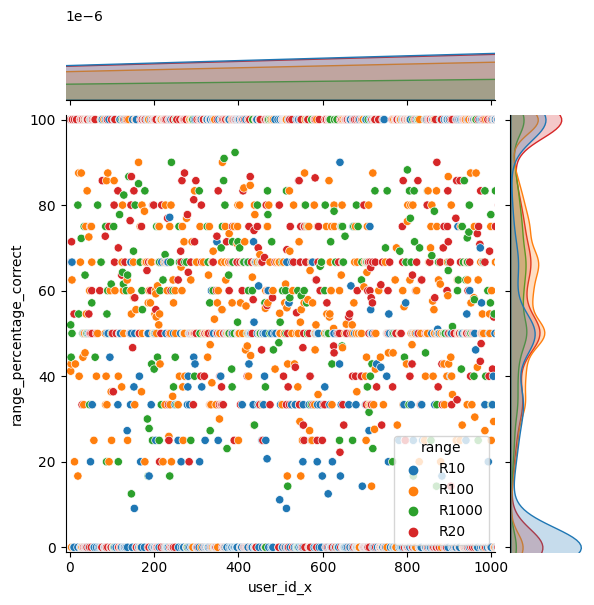

In [44]:
# Your creative visualization here
#first = test.groupby(by=["user_id_x", "game_name", "range"]).apply(lambda x: len(x[(x.hasProperResult == True) & (x.correct == True)])/len(x[(x.hasProperResult == True)])*100)
first = test[test["game_name"] == "Landing"].groupby(by=["user_id_x", "range"]).apply(lambda x: len(x[(x.hasProperResult == True) & (x.correct == True)])/len(x[(x.hasProperResult == True)])*100)

# First calculate the percentage of correct answers for all ranges per user
range_percentage_correct = pd.DataFrame({
    "range_percentage_correct": first#first.groupby(by=["user_id_x", "range"]).mean()
})
# reshape/reform to data usable by the jointplot
range_percentage_correct = range_percentage_correct.stack().reset_index().drop(columns=["level_2"]).rename(columns={0: "range_percentage_correct"})
range_percentage_correct
ax = sns.jointplot(data=range_percentage_correct, y="range_percentage_correct", x="user_id_x", hue="range")
# Make the graph pretty again
ax.ax_marg_x.set_xlim(-10, 1010)
ax.ax_marg_y.set_ylim(-1, 101)
plt.show()

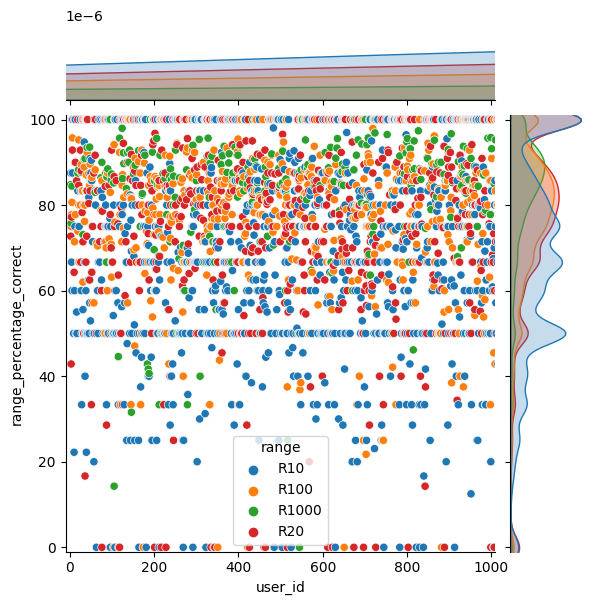

In [45]:
# Your creative visualization here

# First calculate the percentage of correct answers for all ranges per user
range_percentage_correct = pd.DataFrame({
    "range_percentage_correct": subtasks.groupby(by=["user_id", "range"]).apply(lambda x: len(x[(x.hasProperResult == True) & (x.correct == True)])/len(x[(x.hasProperResult == True)])*100)
})
# reshape/reform to data usable by the jointplot
range_percentage_correct = range_percentage_correct.stack().reset_index().drop(columns=["level_2"]).rename(columns={0: "range_percentage_correct"})
ax = sns.jointplot(data=range_percentage_correct, y="range_percentage_correct", x="user_id", hue="range")
# Make the graph pretty again
ax.ax_marg_x.set_xlim(-10, 1010)
ax.ax_marg_y.set_ylim(-1, 101)
plt.show()

In [46]:
# factorize to calculate the pearsons correation
numberized = pd.DataFrame({
    "range_percentage_correct": range_percentage_correct["range_percentage_correct"],
    "range": pd.factorize(range_percentage_correct["range"])[0]
})
corr = np.round(numberized.corr(method='pearson'), 3)
print(f"Pearsons's correlation\n{corr}")

Pearsons's correlation
                          range_percentage_correct  range
range_percentage_correct                      1.00   0.19
range                                         0.19   1.00


*Your discussion goes here*

The hypothesis I was interesting in for the creative extension was the following: "The bigger the number range the participants choose, the better their results will be."
This hypothesis tries to encapsulate the fact that participants might only choose higher number ranges once they are more confident and are better at the skills they need, which they learned beforehand on the lower number ranges.

In the joint plot of all users and the percentage they got of correct answers (again only looking at answers that can be answered correctly), we clearly see that the dirstribution of the higher ranges is more concentrated to the upper percentages of correct answers. All distributions have a tail going towards zero, which is expected because everyone makes mistakes sometimes, regardless of how good they already are. Especially priminent is the R1000 distribution, which seems nicely on the top part of the graph, followed by both the R20 and R100 range, although the R20 range has similar to R10 another bump close to 100%. These two bumps in the higher percentages could be interpreted as those that understand the concepts and still try themselves on the easier problems for confirmation. Another noticable feature is that the distribution for the R10 range, so the easiest one, and most likely the one most participants start and learn with, is far wider and has its center lower than the other three. Another insight that can be gained from the visualization is that most percentages are distributed evenly across all participants.

After looking at this visualization I also added a small pearsons correlation calculation, which turns out to lightly (0.21) correlate the range the user is working on with the percentage of correct answers he is giving.

All in all I am confident in saying that the data supports my hypothesis.